<a href="https://colab.research.google.com/github/Haebuk/dataminingTP/blob/main/TermProject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 아파트 실거래가 예측

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
from tqdm import tqdm

warnings.filterwarnings('ignore')
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.style.use('ggplot')

## Data Load

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
PATH = '/content/drive/MyDrive/input/dataminingTP/'
train_df = pd.read_csv(PATH + 'train.csv')
test_df = pd.read_csv(PATH + 'test.csv')
park_df = pd.read_csv(PATH + 'park.csv')
center_df = pd.read_csv(PATH + 'day_care_center.csv')

In [ ]:
seoul_df = train_df[train_df['city'] == '서울특별시']
busan_df = train_df[train_df['city'] == '부산광역시']
seoul_te = test_df[train_df['city'] == '서울특별시']
busan_te = test_df[train_df['city'] == '부산광역시']

In [ ]:
seoul_df.head(3)

,transaction_id,apartment_id,city,dong,jibun,apt,addr_kr,exclusive_use_area,year_of_completion,transaction_year_month,transaction_date,floor,transaction_real_price
0,0,7622,서울특별시,신교동,6-13,신현(101동),신교동 6-13 신현(101동),84.82,2002,200801,21~31,2,37500
1,1,5399,서울특별시,필운동,142,사직파크맨션,필운동 142 사직파크맨션,99.17,1973,200801,1~10,6,20000
2,2,3578,서울특별시,필운동,174-1,두레엘리시안,필운동 174-1 두레엘리시안,84.74,2007,200801,1~10,6,38500


- exclusive_use_area: 전용면적(한 세대만 독점적으로 사용하는 공간)
- transaction_real_price: 실거래가(단위:만원, 타겟 값, train만 존재)
- transaction_year_month: 거래년월
- transaction_date: 거래일
- floor: 층 

- 데이터가 거래시간 순으로 이루어져 있음

## Preprocessing
### Train and Test set

In [ ]:
train_df.describe() 

,transaction_id,apartment_id,exclusive_use_area,year_of_completion,transaction_year_month,floor,transaction_real_price
count,1.216553e+06,1.216553e+06,1.216553e+06,1.216553e+06,1.216553e+06,1.216553e+06,1.216553e+06
mean,6.091530e+05,6.299685e+03,7.816549e+01,1.998297e+03,2.012984e+05,9.343291e+00,3.822769e+04
std,3.526198e+05,3.581169e+03,2.915113e+01,8.941347e+00,2.905732e+02,6.606500e+00,3.104898e+04
min,0.000000e+00,0.000000e+00,9.260000e+00,1.961000e+03,2.008010e+05,-4.000000e+00,1.000000e+02
25%,3.041380e+05,3.345000e+03,5.976000e+01,1.993000e+03,2.010100e+05,4.000000e+00,1.900000e+04
50%,6.082760e+05,5.964000e+03,8.241000e+01,1.999000e+03,2.013120e+05,8.000000e+00,3.090000e+04
75%,9.124140e+05,9.436000e+03,8.497000e+01,2.005000e+03,2.015110e+05,1.300000e+01,4.700000e+04
max,1.234827e+06,1.265800e+04,4.243200e+02,2.017000e+03,2.017110e+05,8.000000e+01,8.200000e+05


In [ ]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1216553 entries, 0 to 1216552
Data columns (total 13 columns):
 #   Column                  Non-Null Count    Dtype  
---  ------                  --------------    -----  
 0   transaction_id          1216553 non-null  int64  
 1   apartment_id            1216553 non-null  int64  
 2   city                    1216553 non-null  object 
 3   dong                    1216553 non-null  object 
 4   jibun                   1216553 non-null  object 
 5   apt                     1216553 non-null  object 
 6   addr_kr                 1216553 non-null  object 
 7   exclusive_use_area      1216553 non-null  float64
 8   year_of_completion      1216553 non-null  int64  
 9   transaction_year_month  1216553 non-null  int64  
 10  transaction_date        1216553 non-null  object 
 11  floor                   1216553 non-null  int64  
 12  transaction_real_price  1216553 non-null  int64  
dtypes: float64(1), int64(6), object(6)
memory usage: 120.7+ M

- train_df 결측치는 없음
- 1961년 ~ 2017년 완공 건물
- 9.26m^2 ~ 424.32m^2 전용면적
- Floor의 경우 음의 값 존재.
- 실거래가는 100만원부터 820억까지 존재

In [ ]:
train_df.loc[train_df['transaction_real_price']==820000]

,transaction_id,apartment_id,city,dong,jibun,apt,addr_kr,exclusive_use_area,year_of_completion,transaction_year_month,transaction_date,floor,transaction_real_price
23603,23603,11320,서울특별시,한남동,810,한남더힐,한남동 810 한남더힐,244.749,2011,201612,21~31,3,820000


#### Price

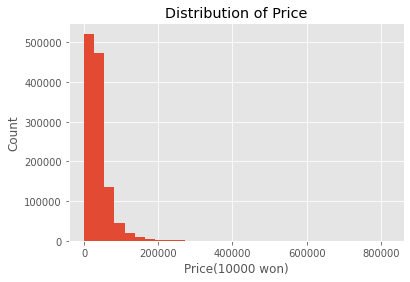

In [ ]:
# train price
plt.figure()
plt.hist(train_df['transaction_real_price'], bins=30)
plt.xlabel('Price(10000 won)')
plt.ylabel('Count')
plt.title('Distribution of Price')
plt.show()

- 가격의 분포가 매우 왼쪽으로 치우친 것을 확인할 수 있음
- 타겟 변수의 이상치가 회귀모형을 사용한 예측에 큰 영향을 줄 수 있음
    - 로그 변환으로 정규화한뒤, 나중에 다시 역변환

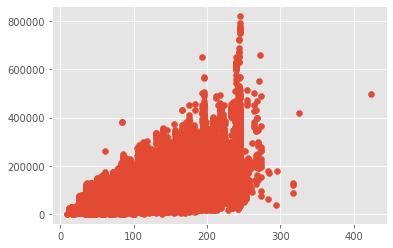

In [ ]:
fig, ax = plt.subplots()
ax.scatter(train_df['exclusive_use_area'], train_df['transaction_real_price'])
plt.show()

#### Area

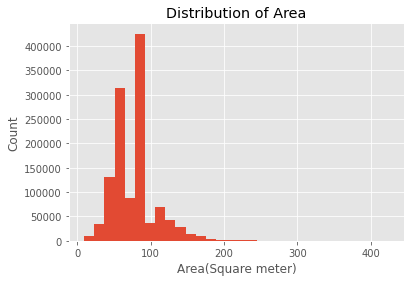

In [ ]:
# train area
plt.figure()
plt.hist(train_df['exclusive_use_area'], bins=30)
plt.xlabel('Area(Square meter)')
plt.ylabel('Count')
plt.title('Distribution of Area')
plt.show()

- 면적도 마찬가지로 정규화

#### What is Underground Floor ?

In [ ]:
under_floor = train_df.loc[train_df['floor']<0]
print(f'총 {under_floor.shape[0]}개의 음수 층 있음')
print(under_floor['floor'].value_counts())

총 168개의 음수 층 있음
-1    140
-2     17
-3      7
-4      4
Name: floor, dtype: int64


- 168개의 지하층이 존재함

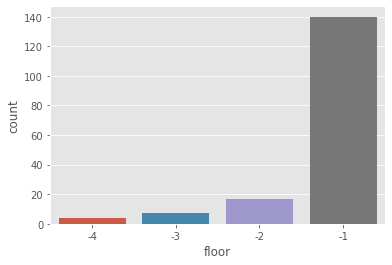

In [ ]:
plt.figure()
sns.countplot(under_floor['floor'])
plt.title('')
plt.show()

In [ ]:
under_floor[['floor', 'transaction_real_price']].corr()

,floor,transaction_real_price
floor,1.000000,-0.126958
transaction_real_price,-0.126958,1.000000


층수와 가격간의 선형 설명력이 어느정도 존재하기 때문에 제거하지 않는다.

In [ ]:
test_df.head()

,transaction_id,apartment_id,city,dong,jibun,apt,addr_kr,exclusive_use_area,year_of_completion,transaction_year_month,transaction_date,floor
0,1145756,10453,서울특별시,목동,938,청학,목동 938 청학,35.5500,2002,201711,11~20,2
1,1198704,989,부산광역시,초량동,1143-8,고관맨션,초량동 1143-8 고관맨션,68.7200,1977,201708,21~31,2
2,1222384,8597,부산광역시,괴정동,447-13,우림그린,괴정동 447-13 우림그린,72.5400,1989,201710,11~20,2
3,1179897,11086,서울특별시,대치동,1007-2,풍림아이원4차(1007-2),대치동 1007-2 풍림아이원4차(1007-2),111.5400,2004,201707,1~10,10
4,1223091,2121,부산광역시,다대동,1670,다대롯데캐슬블루,다대동 1670 다대롯데캐슬블루,119.6398,2014,201712,11~20,21


In [ ]:
test_df.describe()

,transaction_id,apartment_id,exclusive_use_area,year_of_completion,transaction_year_month,floor
count,5.463000e+03,5463.000000,5463.000000,5463.000000,5463.000000,5463.000000
mean,1.167126e+06,6287.570932,79.495250,2000.431082,201710.228446,8.266886
std,4.075365e+04,3624.756304,32.935434,9.982040,2.798195,6.082475
min,1.092791e+06,12.000000,10.321500,1961.000000,201701.000000,-1.000000
25%,1.134296e+06,3278.000000,59.760000,1995.000000,201709.000000,4.000000
50%,1.167937e+06,6091.000000,81.720000,2002.000000,201712.000000,7.000000
75%,1.202560e+06,9416.500000,84.970000,2007.000000,201712.000000,11.000000
max,1.234930e+06,12652.000000,273.860000,2017.000000,201712.000000,55.000000


In [ ]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5463 entries, 0 to 5462
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   transaction_id          5463 non-null   int64  
 1   apartment_id            5463 non-null   int64  
 2   city                    5463 non-null   object 
 3   dong                    5463 non-null   object 
 4   jibun                   5463 non-null   object 
 5   apt                     5463 non-null   object 
 6   addr_kr                 5463 non-null   object 
 7   exclusive_use_area      5463 non-null   float64
 8   year_of_completion      5463 non-null   int64  
 9   transaction_year_month  5463 non-null   int64  
 10  transaction_date        5463 non-null   object 
 11  floor                   5463 non-null   int64  
dtypes: float64(1), int64(5), object(6)
memory usage: 512.3+ KB


- test셋에도 널값은 존재하지 않음.
- 실거래가 변수 없음(타겟 변수)
- 완공연도 1961년부터 2017년
- 실거래연도는 2017년도만 존재함
- 전용면적은 10.32m^2부터 273.86m^2까지 존재

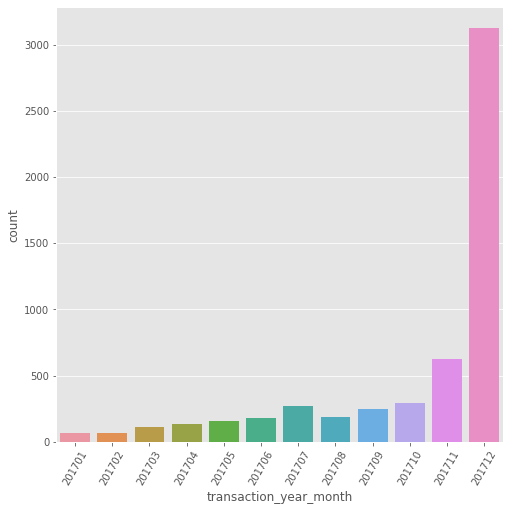

In [ ]:
plt.figure(figsize=(8, 8))
sns.countplot(test_df['transaction_year_month'])
plt.xticks(rotation=60)
plt.show()

2017년 데이터만 존재하며, 12월 데이터가 가장 많음

### Park Data

In [ ]:
park_df.head()

,city,gu,dong,park_name,park_type,park_area,park_exercise_facility,park_entertainment_facility,park_benefit_facility,park_cultural_facitiy,park_facility_other,park_open_year,reference_date
0,부산광역시,남구,대연동,대연공원,근린공원,55227.0,NaN,NaN,NaN,NaN,NaN,1944.0,2018-08-14
1,부산광역시,남구,대연동,당곡공원,역사공원,75465.0,NaN,NaN,NaN,NaN,NaN,1944.0,2018-08-14
2,부산광역시,남구,대연동,대일어린이공원,어린이공원,422.1,NaN,NaN,NaN,NaN,NaN,1965.0,2018-08-14
3,부산광역시,남구,대연동,못골어린이공원,어린이공원,499.8,NaN,NaN,NaN,NaN,NaN,1968.0,2018-08-14
4,부산광역시,남구,용호동,솔밭어린이공원,어린이공원,1500.2,NaN,NaN,NaN,NaN,NaN,1970.0,2018-08-14


- 시설에 매우 많은 결측치가 존재함
- 시설이 존재하면 1 없으면 0으로 값 대체


#### Null Data Replace

In [ ]:
park_df.iloc[:,6:11] = park_df.iloc[:,6:11].notnull().astype(int)
park_df

,city,gu,dong,park_name,park_type,park_area,park_exercise_facility,park_entertainment_facility,park_benefit_facility,park_cultural_facitiy,park_facility_other,park_open_year,reference_date
0,부산광역시,남구,대연동,대연공원,근린공원,55227.0,0,0,0,0,0,1944.0,2018-08-14
1,부산광역시,남구,대연동,당곡공원,역사공원,75465.0,0,0,0,0,0,1944.0,2018-08-14
2,부산광역시,남구,대연동,대일어린이공원,어린이공원,422.1,0,0,0,0,0,1965.0,2018-08-14
3,부산광역시,남구,대연동,못골어린이공원,어린이공원,499.8,0,0,0,0,0,1968.0,2018-08-14
4,부산광역시,남구,용호동,솔밭어린이공원,어린이공원,1500.2,0,0,0,0,0,1970.0,2018-08-14
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1354,서울특별시,구로구,천왕동,이펜시아어린이공원,어린이공원,1500.0,0,1,0,0,0,2006.0,2019-02-25
1355,서울특별시,구로구,천왕동,개명소공원,소공원,5415.0,0,0,0,0,0,2006.0,2019-02-25
1356,서울특별시,구로구,천왕동,봉화대근린공원,근린공원,60975.0,0,0,0,0,0,2006.0,2019-02-25
1357,서울특별시,구로구,항동,푸른수목원,근린공원,100809.0,0,0,0,0,0,2005.0,2019-02-25


#### Park Area

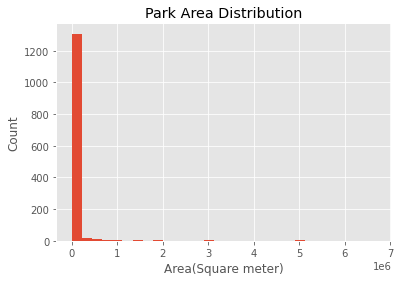

In [ ]:
plt.figure()
plt.hist(park_df['park_area'], bins=30)
plt.xlabel('Area(Square meter)')
plt.ylabel('Count')
plt.title('Park Area Distribution')
plt.show()

- 분포가 매우 왼쪽으로 치우친 형태
- 공원 면적이 집 값에 영향을 미치는가?

#### Facility Correlation 

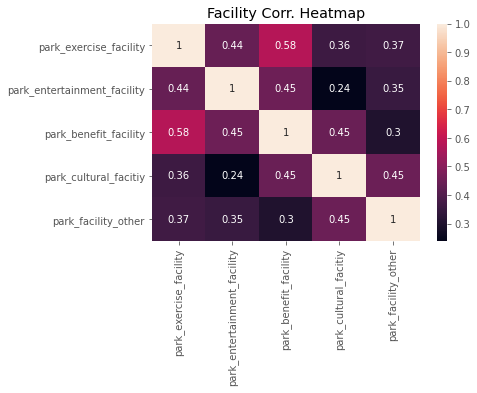

In [ ]:
facility = park_df.iloc[:,6:11]
plt.figure()
sns.heatmap(facility.corr(), annot=True)
plt.title('Facility Corr. Heatmap')
plt.show()

- 공원 시설 간 어느정도 관계는 있으나 다중공선성은 없다고 판단됨.

In [ ]:
park_seoul = park_df[park_df['city']=='서울특별시']
park_busan = park_df[park_df['city']=='부산광역시']

In [ ]:
dong_list =  list(park_seoul['dong'].value_counts().index)
dong_counts =  list(park_seoul['dong'].value_counts().values)

def fill_dong(df, park_df):
    df['count'] = 0
    dong_dict = {}
    dong_list = list(park_df['dong'].value_counts().index)
    dong_counts = list(park_df['dong'].value_counts().values)
    for i, j in zip(dong_list, dong_counts):
        dong_dict[i] = j
    dong_df = pd.Series(dong_dict).to_frame().reset_index().rename(columns = {'index':'dong', 0: 'count'})
    df = pd.merge(df, dong_df, on = 'dong', how = 'left').drop('count_x', axis=1)
    df.rename(columns = {'count_y': 'count'}, inplace = True)
    df['count'].fillna(0, inplace = True)
    return df

In [ ]:
seoul_df = fill_dong(seoul_df, park_seoul)
seoul_te = fill_dong(seoul_te, park_seoul)
busan_df = fill_dong(busan_df, park_busan)
busan_te = fill_dong(busan_te, park_busan)

,transaction_id,apartment_id,city,dong,jibun,apt,addr_kr,exclusive_use_area,year_of_completion,transaction_year_month,transaction_date,floor,transaction_real_price,count
0,650921,3310,부산광역시,영주동,160,동아(160-0),영주동 160 동아(160-0),57.09,1998,200801,1~10,4,7900,3.0
1,650922,2939,부산광역시,영주동,587,도경오벨리스,영주동 587 도경오벨리스,84.97,2005,200801,1~10,12,13000,3.0
2,650923,1704,부산광역시,영주동,161,금호,영주동 161 금호,84.86,1997,200801,11~20,7,12400,3.0
3,650924,3310,부산광역시,영주동,160,동아(160-0),영주동 160 동아(160-0),84.72,1998,200801,11~20,14,10600,3.0
4,650925,1704,부산광역시,영주동,161,금호,영주동 161 금호,84.59,1997,200801,21~31,5,10000,3.0


In [ ]:
seoul_df[seoul_df['dong']=='중곡동']

,transaction_id,apartment_id,city,dong,jibun,apt,addr_kr,exclusive_use_area,year_of_completion,transaction_year_month,transaction_date,floor,transaction_real_price,count
45740,45740,2616,서울특별시,중곡동,68-6,대영,중곡동 68-6 대영,57.94,2002,200801,11~20,5,13500,0.0
45741,45741,8035,서울특별시,중곡동,292,에스케이,중곡동 292 에스케이,84.60,1999,200801,21~31,3,37100,0.0
45847,45847,9901,서울특별시,중곡동,191-77,중곡1단지,중곡동 191-77 중곡1단지,48.46,1976,200802,1~10,4,15000,0.0
45848,45848,6638,서울특별시,중곡동,681,성원,중곡동 681 성원,59.82,1998,200802,1~10,4,18800,0.0
45849,45849,8346,서울특별시,중곡동,110-33,예다움,중곡동 110-33 예다움,84.71,2004,200802,11~20,3,26000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
660403,1103397,9902,서울특별시,중곡동,190-26,중곡2단지,중곡동 190-26 중곡2단지,55.87,1976,201710,11~20,5,25000,0.0
660404,1103398,9901,서울특별시,중곡동,191-77,중곡1단지,중곡동 191-77 중곡1단지,48.50,1976,201710,21~31,3,20000,0.0
660405,1103399,6638,서울특별시,중곡동,681,성원,중곡동 681 성원,59.82,1998,201710,21~31,7,29400,0.0
660558,1103561,9902,서울특별시,중곡동,190-26,중곡2단지,중곡동 190-26 중곡2단지,55.87,1976,201711,11~20,5,24850,0.0


### Center

center의 경우 '동'으로 매핑할 수 없음.
1. center 수용인원을 4분위 수로 나눠서 해당하는지 안하는지 - 원핫?
2. 여기서는 '구'로 count sum?
3. 통학버스가 없는 경우 0.8정도 count?

In [ ]:
center_df.head()

,city,gu,day_care_name,day_care_type,day_care_baby_num,teacher_num,nursing_room_num,playground_num,CCTV_num,is_commuting_vehicle,reference_date
0,서울특별시,서대문구,가람어린이집,국공립,70,11.0,5.0,1.0,7.0,N,2018-07-31
1,서울특별시,서대문구,가좌제일어린이집,국공립,88,22.0,5.0,2.0,10.0,N,2018-07-31
2,서울특별시,서대문구,경찰청어린이집,직장,90,23.0,6.0,1.0,32.0,N,2018-07-31
3,서울특별시,서대문구,고운햇살어린이집,가정,18,5.0,3.0,0.0,4.0,N,2018-07-31
4,서울특별시,서대문구,고은어린이집,국공립,93,20.0,7.0,2.0,10.0,N,2018-07-31


In [ ]:
center_df.describe()

,day_care_baby_num,teacher_num,nursing_room_num,playground_num,CCTV_num
count,7551.000000,7326.000000,4352.000000,3626.000000,5280.000000
mean,44.396636,9.013514,4.528033,0.398235,6.676136
std,37.022079,5.809909,2.075709,0.730602,4.482168
min,5.000000,0.000000,0.000000,0.000000,0.000000
25%,19.000000,6.000000,3.000000,0.000000,4.000000
50%,29.000000,7.000000,4.000000,0.000000,5.000000
75%,60.000000,11.000000,5.000000,1.000000,8.000000
max,489.000000,98.000000,22.000000,16.000000,53.000000


In [ ]:
center_df.isna().sum()

city                       0
gu                         0
day_care_name              0
day_care_type              0
day_care_baby_num          0
teacher_num              225
nursing_room_num        3199
playground_num          3925
CCTV_num                2271
is_commuting_vehicle     496
reference_date             0
dtype: int64

In [ ]:
center_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7551 entries, 0 to 7550
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   city                  7551 non-null   object 
 1   gu                    7551 non-null   object 
 2   day_care_name         7551 non-null   object 
 3   day_care_type         7551 non-null   object 
 4   day_care_baby_num     7551 non-null   int64  
 5   teacher_num           7326 non-null   float64
 6   nursing_room_num      4352 non-null   float64
 7   playground_num        3626 non-null   float64
 8   CCTV_num              5280 non-null   float64
 9   is_commuting_vehicle  7055 non-null   object 
 10  reference_date        7551 non-null   object 
dtypes: float64(4), int64(1), object(6)
memory usage: 649.0+ KB


In [ ]:
center_df['is_commuting_vehicle'].value_counts()

N    4102
Y    2446
      401
y      88
n      18
Name: is_commuting_vehicle, dtype: int64

- is_commuting_vehicle에는 nan값과 공백값이 각각 496개, 401개 존재함
- 먼저 소문자를 대문자로 바꿈

In [ ]:
center_df.replace('y','Y',inplace=True)
center_df.replace('n','N',inplace=True)

Text(0.5, 1.0, 'Day Care Type Count Plot')

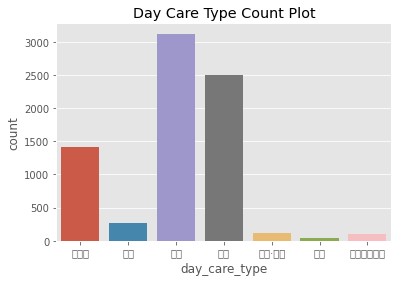

In [ ]:
plt.figure()
sns.countplot(center_df['day_care_type'])
plt.title('Day Care Type Count Plot')
plt.show()

- 통근 차량 결측치를 처리하기 위해 각 day_care_type의 Y값 보다 작으면 N, 크면 Y로 대체

In [ ]:
center_df.groupby(['day_care_type','is_commuting_vehicle'])['day_care_baby_num'].mean()

day_care_type  is_commuting_vehicle
가정                                     18.390071
               N                       18.166359
               Y                       19.014129
국공립                                    62.319149
               N                       60.781800
               Y                       79.366279
민간                                     63.326531
               N                       44.377634
               Y                       66.266496
법인·단체                                  51.600000
               N                       50.313725
               Y                       78.272727
사회복지법인                                 44.250000
               N                       83.476190
               Y                       87.901235
직장                                     43.375000
               N                       73.267943
               Y                       70.409091
협동                                     38.000000
               N                 

In [ ]:
# 결측치 중 평균 
center_df.loc[(center_df['is_commuting_vehicle'].isnull()) & (center_df['day_care_type']=='가정') & (center_df['day_care_baby_num'] < 19), 'is_commuting_vehicle'] = 'N'
center_df.loc[(center_df['is_commuting_vehicle'].isnull()) & (center_df['day_care_type']=='국공립') & (center_df['day_care_baby_num'] < 79), 'is_commuting_vehicle'] = 'N'
center_df.loc[(center_df['is_commuting_vehicle'].isnull()) & (center_df['day_care_type']=='민간') & (center_df['day_care_baby_num'] < 66), 'is_commuting_vehicle'] = 'N'
center_df.loc[(center_df['is_commuting_vehicle'].isnull()) & (center_df['day_care_type']=='법인·단체') & (center_df['day_care_baby_num'] < 78), 'is_commuting_vehicle'] = 'N'
center_df.loc[(center_df['is_commuting_vehicle'].isnull()) & (center_df['day_care_type']=='사회복지법인') & (center_df['day_care_baby_num'] < 87), 'is_commuting_vehicle'] = 'N'
center_df.loc[(center_df['is_commuting_vehicle'].isnull()) & (center_df['day_care_type']=='직장') & (center_df['day_care_baby_num'] < 70), 'is_commuting_vehicle'] = 'N'
center_df.loc[(center_df['is_commuting_vehicle'].isnull()) & (center_df['day_care_type']=='협동') & (center_df['day_care_baby_num'] < 33), 'is_commuting_vehicle'] = 'N'
# 공백값 중 평균
center_df.loc[(center_df['is_commuting_vehicle'] == ' ') & (center_df['day_care_type']=='가정') & (center_df['day_care_baby_num'] < 19), 'is_commuting_vehicle'] = 'N'
center_df.loc[(center_df['is_commuting_vehicle'] == ' ') & (center_df['day_care_type']=='국공립') & (center_df['day_care_baby_num'] < 79), 'is_commuting_vehicle'] = 'N'
center_df.loc[(center_df['is_commuting_vehicle'] == ' ') & (center_df['day_care_type']=='민간') & (center_df['day_care_baby_num'] < 66), 'is_commuting_vehicle'] = 'N'
center_df.loc[(center_df['is_commuting_vehicle'] == ' ') & (center_df['day_care_type']=='법인·단체') & (center_df['day_care_baby_num'] < 78), 'is_commuting_vehicle'] = 'N'
center_df.loc[(center_df['is_commuting_vehicle'] == ' ') & (center_df['day_care_type']=='사회복지법인') & (center_df['day_care_baby_num'] < 87), 'is_commuting_vehicle'] = 'N'
center_df.loc[(center_df['is_commuting_vehicle'] == ' ') & (center_df['day_care_type']=='직장') & (center_df['day_care_baby_num'] < 70), 'is_commuting_vehicle'] = 'N'
center_df.loc[(center_df['is_commuting_vehicle'] == ' ') & (center_df['day_care_type']=='협동') & (center_df['day_care_baby_num'] < 33), 'is_commuting_vehicle'] = 'N'
# 나머지 nan값을 Y로 대체
center_df['is_commuting_vehicle'].replace(' ', 'Y', inplace=True)
center_df['is_commuting_vehicle'].replace(np.nan, 'Y', inplace=True)
# N을 0으로, Y를 1로 대체
center_df['is_commuting_vehicle'].replace('N', 0, inplace=True)
center_df['is_commuting_vehicle'].replace('Y', 1, inplace=True)


print(center_df['is_commuting_vehicle'].value_counts(),'\n', center_df['is_commuting_vehicle'].notnull().sum())

0    4557
1    2994
Name: is_commuting_vehicle, dtype: int64 
 7551


Text(0.5, 1.0, 'Commuting Vehicle Count Plot')

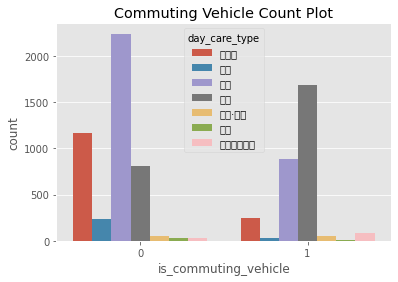

In [ ]:
plt.figure()
sns.countplot(center_df['is_commuting_vehicle'], hue='day_care_type', data=center_df)
plt.title('Commuting Vehicle Count Plot')
plt.show()

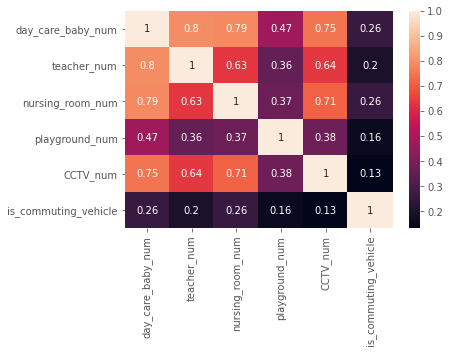

In [ ]:
sns.heatmap(center_df.corr(), annot=True)
plt.show()

#### CCTV_num, playground_num, nursing_room_num 결측치
결측치를 처리하기 까다롭고, 다중공선성이 우려되어 피쳐를 삭제하기로 결정

In [ ]:
center_df.drop(columns=['playground_num', 'nursing_room_num', 'CCTV_num'], inplace=True)
center_df

,city,gu,day_care_name,day_care_type,day_care_baby_num,teacher_num,is_commuting_vehicle,reference_date
0,서울특별시,서대문구,가람어린이집,국공립,70,11.0,0,2018-07-31
1,서울특별시,서대문구,가좌제일어린이집,국공립,88,22.0,0,2018-07-31
2,서울특별시,서대문구,경찰청어린이집,직장,90,23.0,0,2018-07-31
3,서울특별시,서대문구,고운햇살어린이집,가정,18,5.0,0,2018-07-31
4,서울특별시,서대문구,고은어린이집,국공립,93,20.0,0,2018-07-31
...,...,...,...,...,...,...,...,...
7546,부산광역시,금정구,해바라기어린이집,민간,46,13.0,1,2019-01-21
7547,부산광역시,금정구,해수어린이집,가정,19,6.0,1,2019-01-21
7548,부산광역시,금정구,행복한그림동산어린이집,민간,92,16.0,1,2019-01-21
7549,부산광역시,금정구,행복한어린이집,민간,43,12.0,1,2019-01-21


#### 보육시설 원핫인코딩

In [ ]:
center_oh = pd.get_dummies(center_df['day_care_type'])
center_oh

,가정,국공립,민간,법인·단체,사회복지법인,직장,협동
0,0,1,0,0,0,0,0
1,0,1,0,0,0,0,0
2,0,0,0,0,0,1,0
3,1,0,0,0,0,0,0
4,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...
7546,0,0,1,0,0,0,0
7547,1,0,0,0,0,0,0
7548,0,0,1,0,0,0,0
7549,0,0,1,0,0,0,0


In [ ]:
center_df = pd.concat([center_df, center_oh], axis=1)
center_df.drop(columns='day_care_type', inplace=True)
center_df

,city,gu,day_care_name,day_care_baby_num,teacher_num,is_commuting_vehicle,reference_date,가정,국공립,민간,법인·단체,사회복지법인,직장,협동
0,서울특별시,서대문구,가람어린이집,70,11.0,0,2018-07-31,0,1,0,0,0,0,0
1,서울특별시,서대문구,가좌제일어린이집,88,22.0,0,2018-07-31,0,1,0,0,0,0,0
2,서울특별시,서대문구,경찰청어린이집,90,23.0,0,2018-07-31,0,0,0,0,0,1,0
3,서울특별시,서대문구,고운햇살어린이집,18,5.0,0,2018-07-31,1,0,0,0,0,0,0
4,서울특별시,서대문구,고은어린이집,93,20.0,0,2018-07-31,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7546,부산광역시,금정구,해바라기어린이집,46,13.0,1,2019-01-21,0,0,1,0,0,0,0
7547,부산광역시,금정구,해수어린이집,19,6.0,1,2019-01-21,1,0,0,0,0,0,0
7548,부산광역시,금정구,행복한그림동산어린이집,92,16.0,1,2019-01-21,0,0,1,0,0,0,0
7549,부산광역시,금정구,행복한어린이집,43,12.0,1,2019-01-21,0,0,1,0,0,0,0


In [ ]:
drop_cols = ['city', 'transaction_id', 'jibun', 'apt', 'addr_kr', 'transaction_date']
seoul_df2 = seoul_df.drop(drop_cols, axis=1)
busan_df2 = busan_df.drop(drop_cols, axis=1)
seoul_te_df2 = seoul_te.drop(drop_cols, axis=1)
busan_te_df2 = busan_te.drop(drop_cols, axis=1)

In [ ]:
pd.get_dummies(seoul_df2['dong'])

,가락동,가리봉동,가산동,가양동,갈월동,갈현동,강일동,개봉동,개포동,거여동,견지동,고덕동,고척동,공덕동,공릉동,공항동,광장동,교남동,교북동,구기동,구로동,구산동,구수동,구의동,군자동,궁동,금호동1가,금호동2가,금호동3가,금호동4가,길동,길음동,낙원동,남가좌동,남대문로5가,남산동2가,남창동,남현동,내곡동,내발산동,...,충정로2가,충정로3가,토정동,통인동,평창동,풍납동,필동1가,필동3가,필운동,하계동,하왕십리동,하월곡동,하중동,한강로1가,한강로2가,한강로3가,한남동,합동,합정동,항동,행당동,행촌동,현석동,현저동,혜화동,홍은동,홍익동,홍제동,화곡동,화양동,황학동,회기동,회현동1가,회현동2가,효제동,효창동,후암동,휘경동,흑석동,흥인동
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
742280,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
742281,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
742282,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
742283,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
from sklearn.linear_model import ElasticNet, Lasso,  BayesianRidge, LassoLarsIC
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error
import xgboost as xgb
import lightgbm as lgb

In [ ]:
lasso = make_pipeline(RobustScaler(), Lasso(alpha=0.0005, random_state=1))

In [ ]:
n_folds = 5
